In [68]:
import tensorflow as tf
from src.utils.layers import CNNBlock, BlockLayer
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16

In [69]:
def VGG_Model():
    vgg = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    output_layers = [
        'block1_conv2',
        'block2_conv2',
        'block3_conv3',
        'block4_conv3',
        # 'block5_conv3',
        'block4_pool',
    ]
    output = [vgg.get_layer(layer).output for layer in output_layers]

    model = models.Model(inputs=vgg.input, outputs=output)
    model.trainable = False
    return model

In [70]:
vgg_model = VGG_Model()

In [71]:
vgg_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [72]:
from tensorflow.keras.utils import plot_model

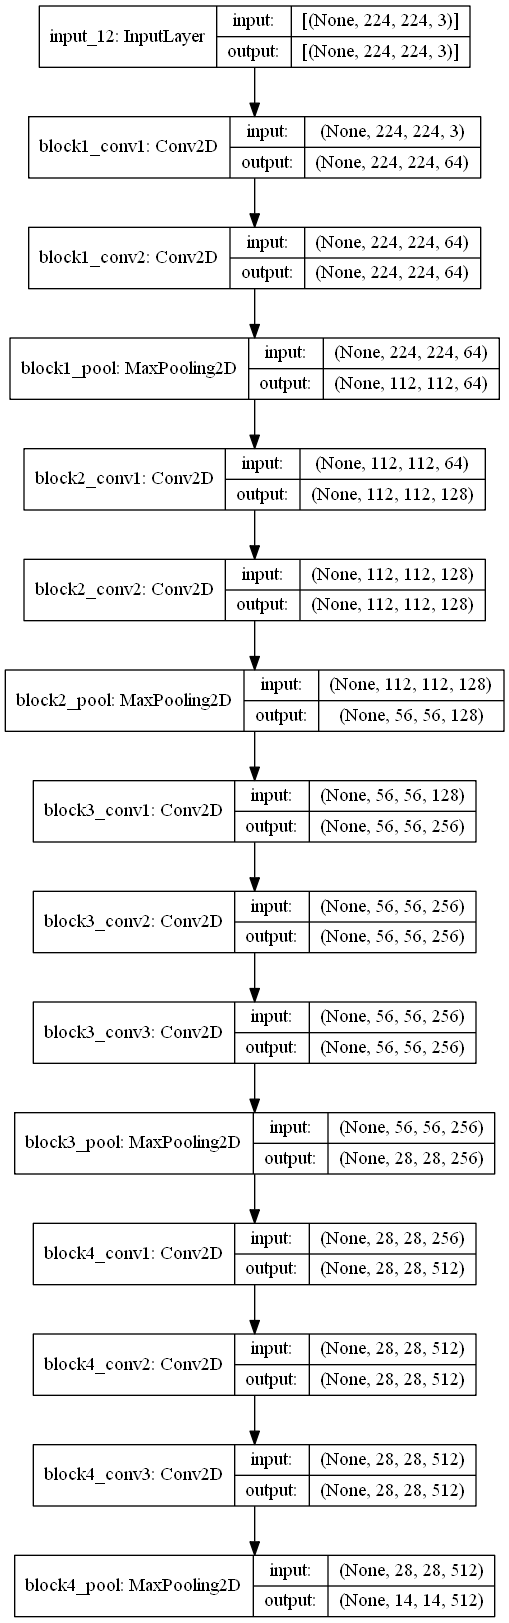

In [73]:
plot_model(vgg_model, show_shapes=True )

In [74]:
def UNet(out_channels=2, features=[64, 128, 256, 512]):
    input = layers.Input(shape=(224, 224, 3))
    x = VGG_Model()(input)
    skip_connections = x[:-1]
    x = x[-1]
    x = CNNBlock(features[-1]*2)(x)
    x = CNNBlock(features[-1]*2)(x)

    skip_connections = skip_connections[::-1]

    for idx, feature in enumerate(reversed(features)):
        x = layers.Conv2DTranspose(
            feature, kernel_size=2, strides=2, padding="same")(x)
        skip_connection = skip_connections[idx]
        crop_amount = (skip_connection.shape[1] - x.shape[1]) // 2
        if x.shape != skip_connection.shape:
            skip_connection = tf.keras.layers.Cropping2D(
                cropping=crop_amount)(skip_connection)

        x = layers.Concatenate()([x, skip_connection])
        x = CNNBlock(feature*2)(x)
        x = CNNBlock(feature*2)(x)

    x = layers.Conv2D(out_channels, kernel_size=1)(x)
    x = layers.Softmax()(x)
    model = models.Model(inputs=input, outputs=x)
    return model

In [75]:
model = UNet()

In [76]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_12 (Functional)           [(None, 224, 224, 64 7635264     input_13[0][0]                   
__________________________________________________________________________________________________
cnn_block_42 (CNNBlock)         (None, 14, 14, 1024) 4723712     model_12[0][4]                   
__________________________________________________________________________________________________
cnn_block_43 (CNNBlock)         (None, 14, 14, 1024) 9442304     cnn_block_42[0][0]               
___________________________________________________________________________________________

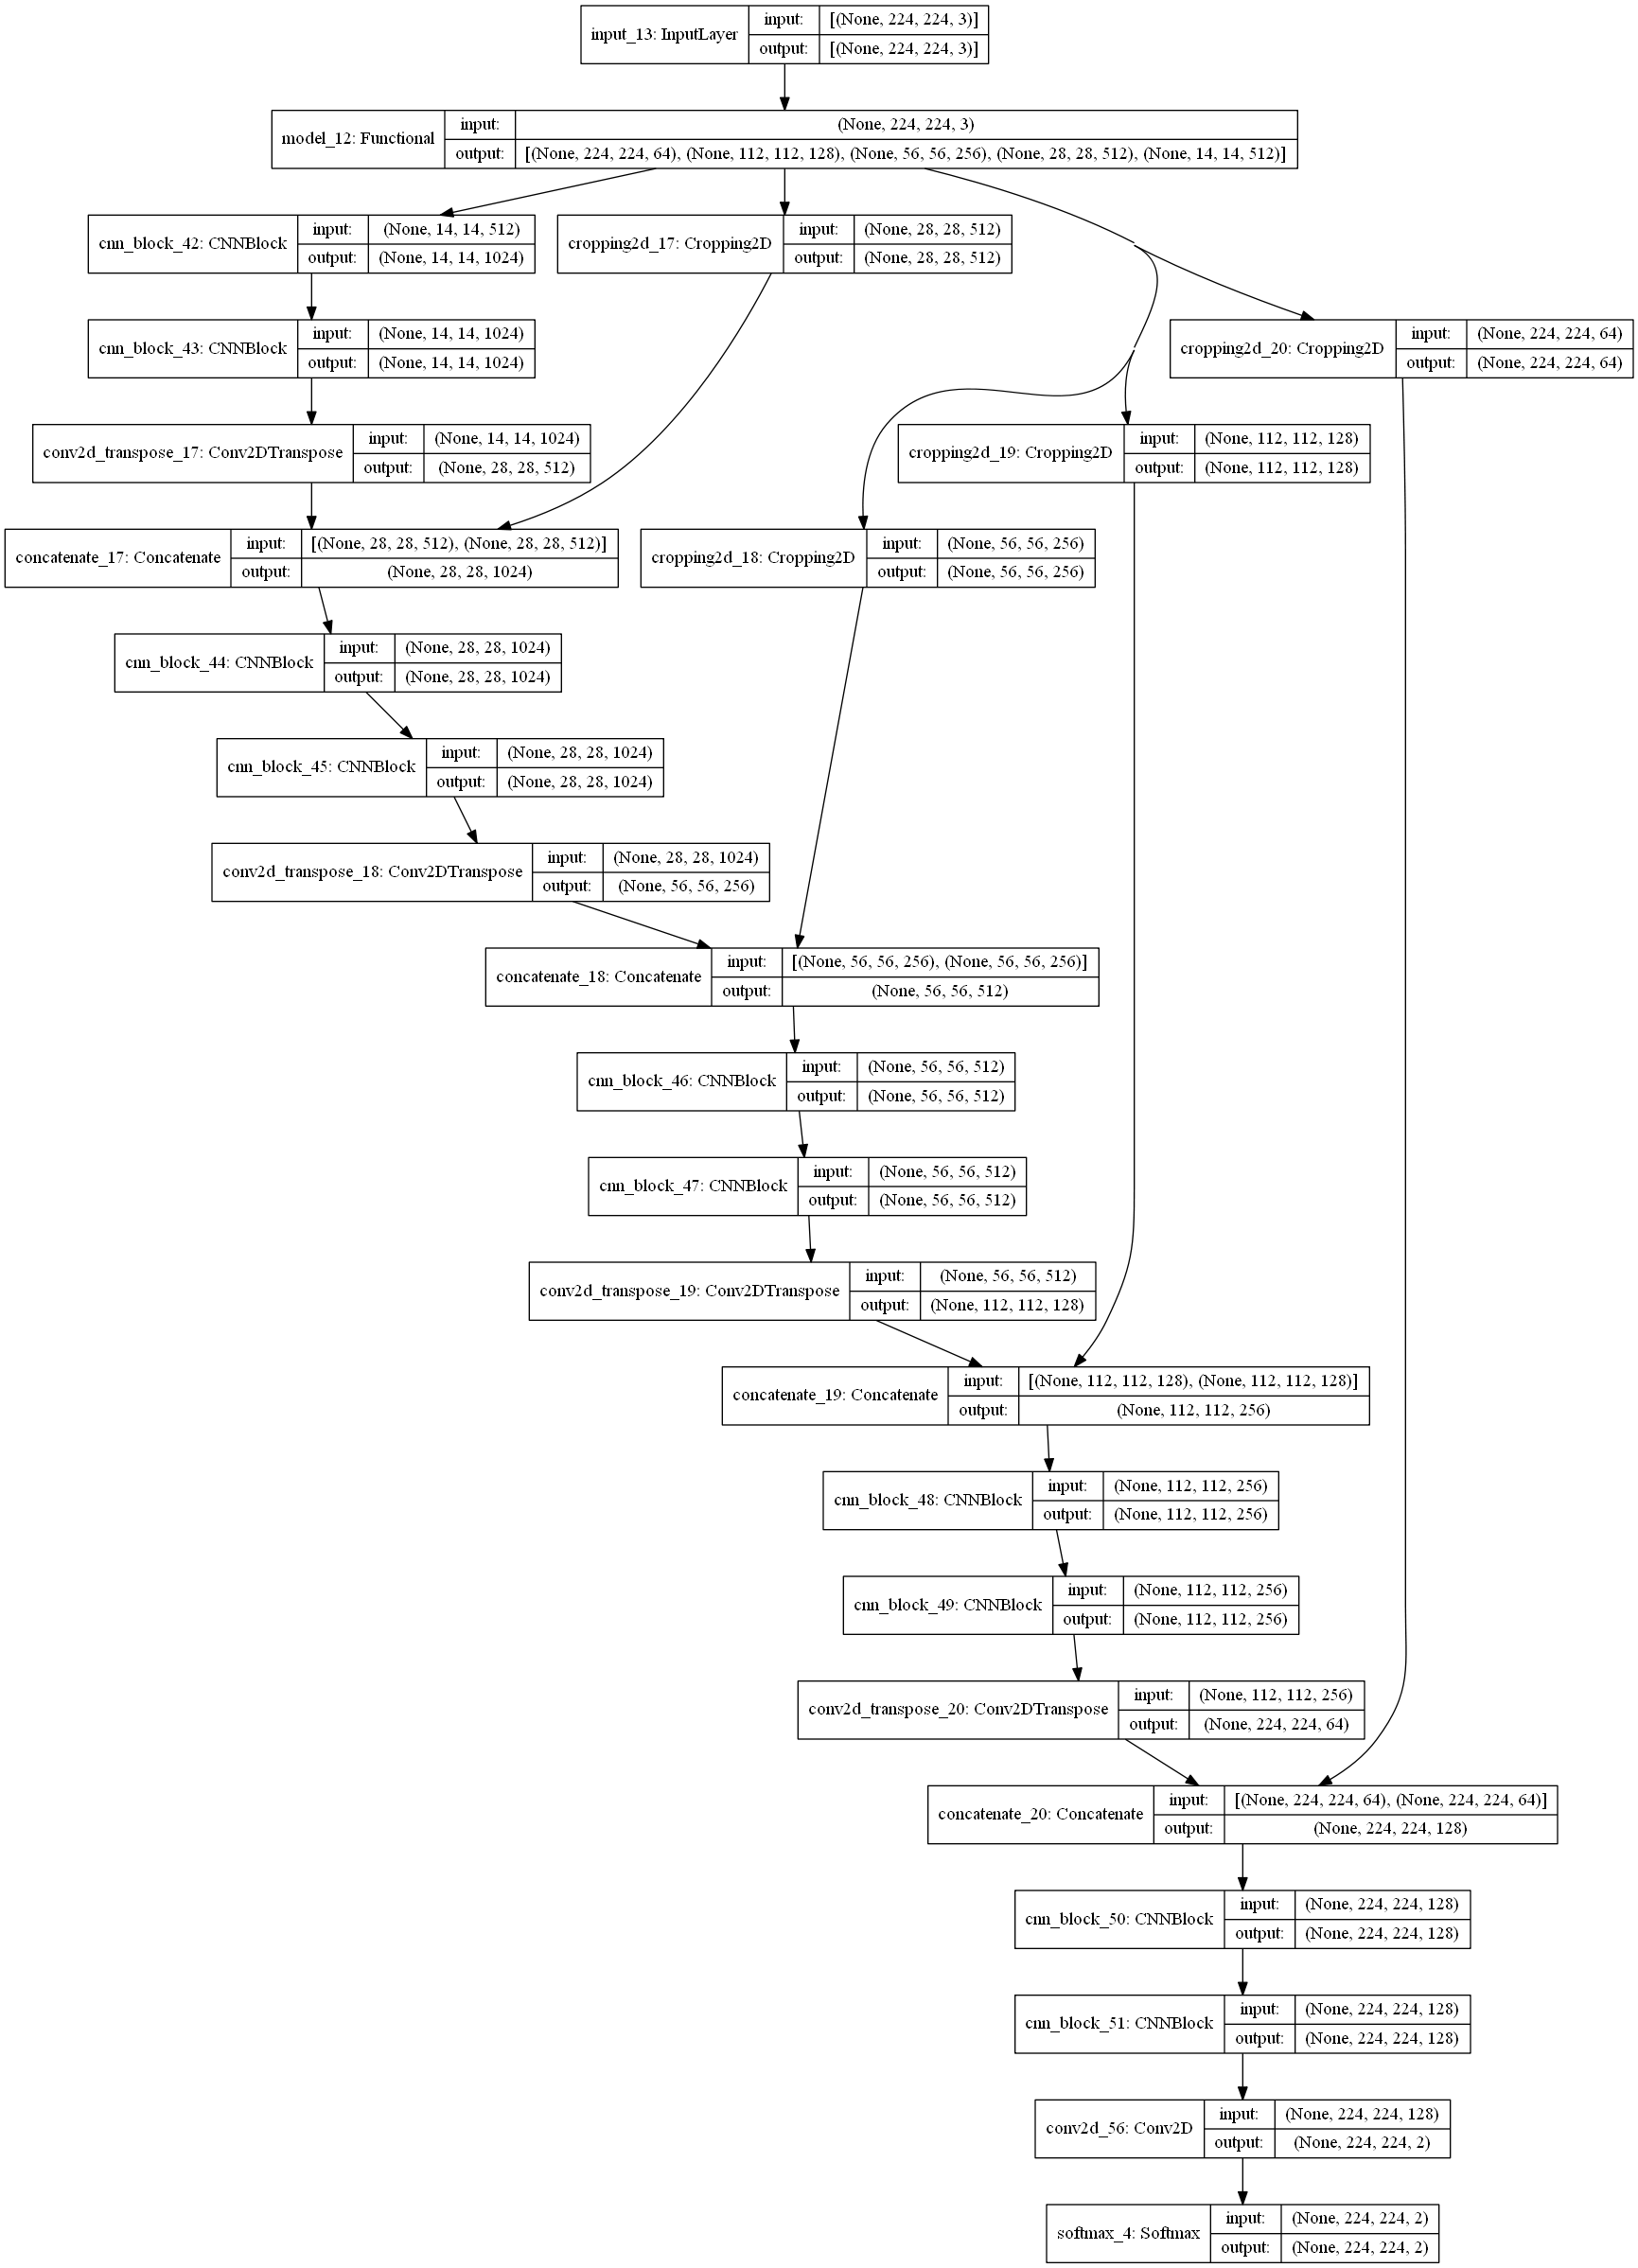

In [77]:
plot_model(model, show_shapes=True)

In [78]:
from src.models.train_model import checkpoints

In [79]:
model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [80]:
from src.data.make_dataset import Dataset

In [81]:
dataset = Dataset(root_dir=ROOT_DIR,
                      batch_size=1, validation=True)

In [82]:
train_dataset, validation_dataset, test_dataset = dataset.make()

In [83]:
history_ = model.fit(train_dataset, steps_per_epoch=100, epochs=5, validation_data=(
        validation_dataset), validation_steps=50, verbose=1)

Epoch 1/5
100/100 [==============================] - 527s 5s/step - loss: 0.5706 - accuracy: 0.7218 - val_loss: 0.9521 - val_accuracy: 0.3575
Epoch 2/5
100/100 [==============================] - 509s 5s/step - loss: 0.5370 - accuracy: 0.7651 - val_loss: 0.8926 - val_accuracy: 0.4109
Epoch 3/5
100/100 [==============================] - 509s 5s/step - loss: 0.5091 - accuracy: 0.7938 - val_loss: 0.6488 - val_accuracy: 0.6543
Epoch 4/5
100/100 [==============================] - 510s 5s/step - loss: 0.5096 - accuracy: 0.7911 - val_loss: 0.6866 - val_accuracy: 0.6143
Epoch 5/5
100/100 [==============================] - 511s 5s/step - loss: 0.4859 - accuracy: 0.8176 - val_loss: 0.5330 - val_accuracy: 0.7722


In [101]:
model.evaluate(test_dataset, steps = 100)

100/100 [==============================] - 123s 1s/step - loss: 0.5199 - accuracy: 0.7860


[0.5199330449104309, 0.7860379219055176]

In [91]:
import pandas as pd
pd.DataFrame(history_.history)

,loss,accuracy,val_loss,val_accuracy
0,0.535803,0.764034,0.952139,0.357543
1,0.533710,0.768548,0.892576,0.410945
2,0.506115,0.796861,0.648792,0.654265
3,0.483594,0.818649,0.686588,0.614251
4,0.476944,0.827538,0.533022,0.772195


In [92]:
import matplotlib.pyplot as plt

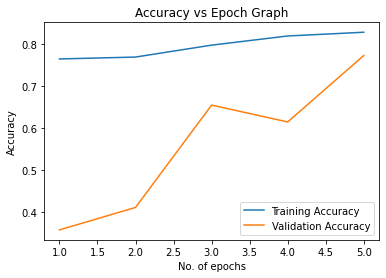

In [95]:
plt.plot(range(1,6), history_.history['accuracy'], label="Training Accuracy")
plt.plot(range(1,6), history_.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy vs Epoch Graph")
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

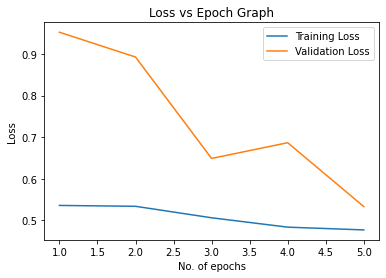

In [97]:
plt.plot(range(1,6), history_.history['loss'], label="Training Loss")
plt.plot(range(1,6), history_.history['val_loss'], label="Validation Loss")
plt.title("Loss vs Epoch Graph")
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [117]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, image, mask):
    prediction = model.predict(image[tf.newaxis, ...])
    display([image, mask, create_mask(prediction)])


def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

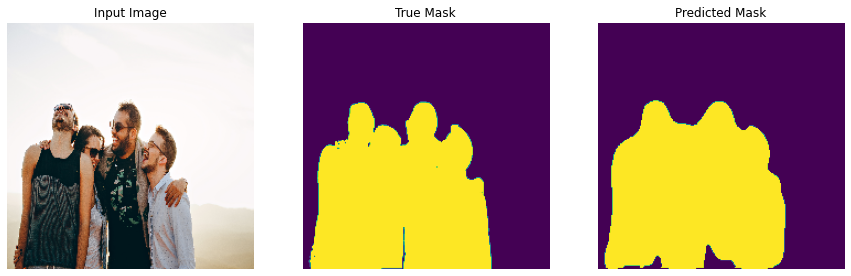

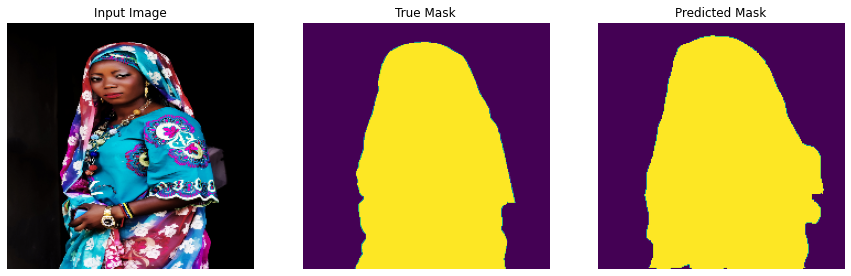

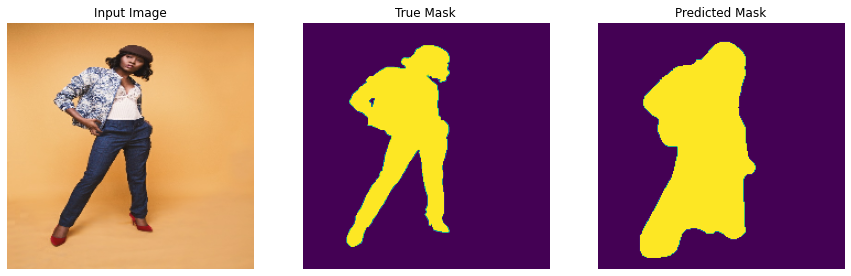

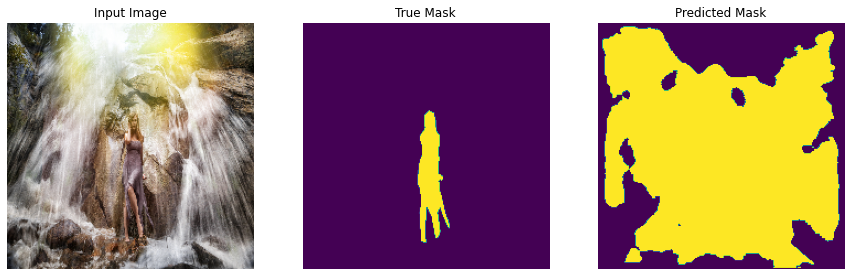

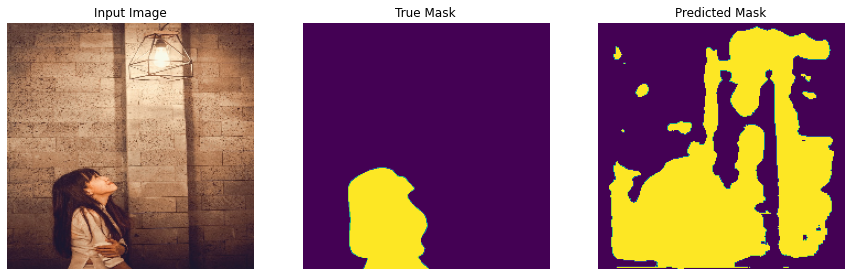

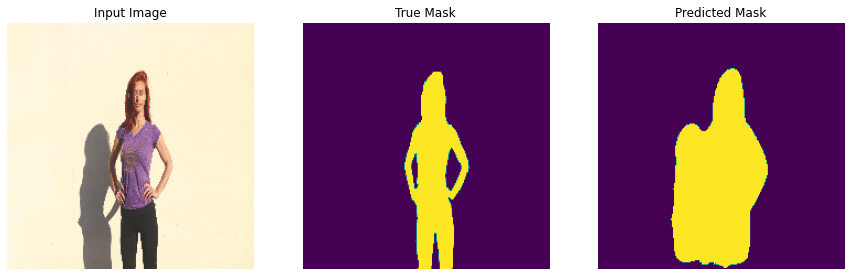

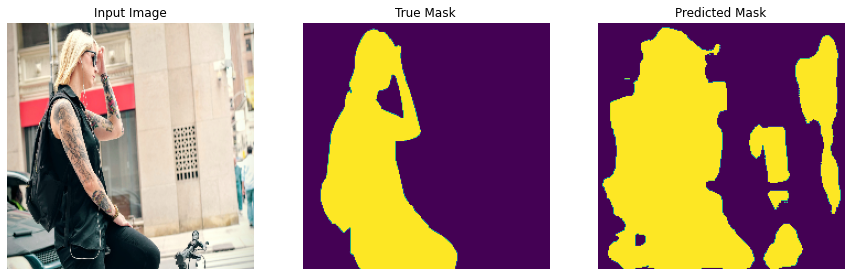

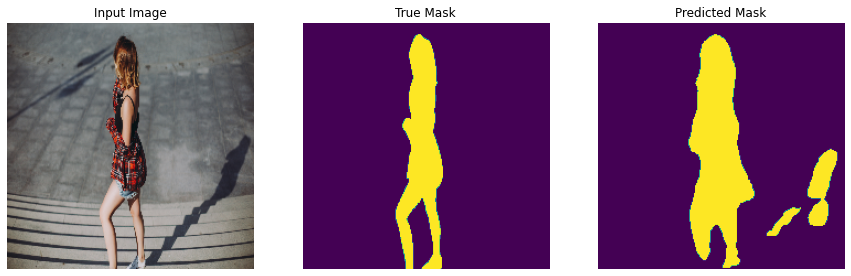

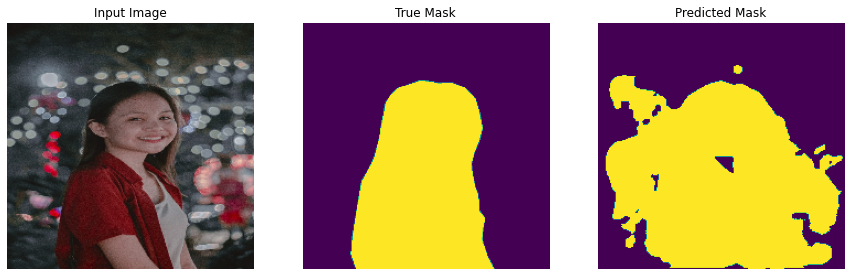

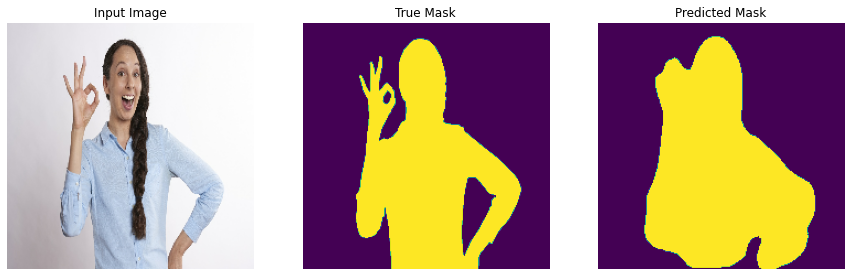

In [118]:
for image in test_dataset.take(10):
    show_predictions(model, image[0][0], image[1][0])